# Channel Head Coupling & Lengthwise Asymmetry Analysis - All Basins

This notebook performs full analysis of coupled channel heads for **all available basins** including:
- **Coupling Analysis**: Detecting spatially touching channel head basins
- **Lengthwise Asymmetry (ΔL)**: Measuring flow path length differences (Goren & Shelef 2024)

Basins analyzed:
- **Inyo Mountains, California** (z_th = 1200 m)
- **Humboldt Range, Nevada** (z_th = 1450 m)
- **Clan Alpine Mountains, Nevada** (z_th = 1700 m)
- **Daqing Shan, China** (z_th = 1200 m)
- **Kammanassie Mountains, South Africa** (z_th = 630 m)
- **Lüliang Mountains, China** (z_th = 1100 m)

## 1. Setup and Imports

In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import topotoolbox as tt3

# Add project root so "channel_heads" package is visible
project_root = pathlib.Path("/Users/guypi/Projects/channel-heads")
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Core analysis imports
from channel_heads import (
    CouplingAnalyzer,
    first_meet_pairs_for_outlet,
    outlet_node_ids_from_streampoi,
    # Lengthwise asymmetry
    LengthwiseAsymmetryAnalyzer,
    compute_asymmetry_statistics,
    merge_coupling_and_asymmetry,
    # Basin configuration
    get_z_th,
    get_basin_config,
    get_reference_delta_L,
    BASIN_CONFIG,
)

# Plotting utilities
from channel_heads.plotting_utils import (
    plot_coupled_pair,
    plot_outlet_view,
    plot_all_coupled_pairs_for_outlet,
)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
%matplotlib inline

print("Setup complete!")

Setup complete!


## 2. Basin Configuration

Load basin parameters from Goren & Shelef (2024) Table A1.

In [2]:
# Define basins to analyze with their DEM paths
DATA_DIR = pathlib.Path("/Users/guypi/Projects/channel-heads/data/cropped_DEMs")
OUTPUT_DIR = pathlib.Path("/Users/guypi/Projects/channel-heads/data/outputs")

# All available basins
BASINS_TO_ANALYZE = {
    "inyo": {
        "dem_path": DATA_DIR / "Inyo_strm_crop.tif",
        "paper_name": "inyo",
    },
    "humboldt": {
        "dem_path": DATA_DIR / "Humboldt_strm_crop.tif",
        "paper_name": "humboldt",
    },
    "calnalpine": {
        "dem_path": DATA_DIR / "CalnAlpine_strm_crop.tif",
        "paper_name": "calnalpine",
    },
    "daqing": {
        "dem_path": DATA_DIR / "Daqing_strm_crop.tif",
        "paper_name": "daqing",
    },
    "kammanasie": {
        "dem_path": DATA_DIR / "Kammanasie_strm_crop.tif",
        "paper_name": "kammanasie",
    },
    "luliang": {
        "dem_path": DATA_DIR / "Luliang_strm_crop.tif",
        "paper_name": "luliang",
    },
}

# Stream extraction threshold (default: 145)
STREAM_THRESHOLD = 145

# Show basin configurations
print("=" * 70)
print("Basin Configuration from Goren & Shelef (2024)")
print(f"Stream threshold: {STREAM_THRESHOLD}")
print("=" * 70)

for name, config in BASINS_TO_ANALYZE.items():
    basin_config = get_basin_config(config["paper_name"])
    ref_delta_L = get_reference_delta_L(config["paper_name"])
    dem_exists = config['dem_path'].exists()
    status = "✓" if dem_exists else "✗ MISSING"
    print(f"\n{basin_config['full_name']} [{status}]")
    print(f"  z_th: {basin_config['z_th']} m")
    print(f"  z_max: {basin_config['z_max']} m")
    print(f"  lat: {basin_config['lat']}°")
    print(f"  θ (concavity): {basin_config['theta']:.2f}")
    print(f"  Reference ΔL: {ref_delta_L['median']:.2f} ({ref_delta_L['p25']:.2f} - {ref_delta_L['p75']:.2f})")

Basin Configuration from Goren & Shelef (2024)
Stream threshold: 145

Inyo Mountains, California [✓]
  z_th: 1200 m
  z_max: 3363 m
  lat: 36.71°
  θ (concavity): 0.35
  Reference ΔL: 0.17 (0.08 - 0.34)

Humboldt Range, Nevada [✓]
  z_th: 1450 m
  z_max: 2984 m
  lat: 40.52°
  θ (concavity): 0.46
  Reference ΔL: 0.34 (0.13 - 0.61)

Clan Alpine Mountains, Nevada [✓]
  z_th: 1700 m
  z_max: 2677 m
  lat: 39.69°
  θ (concavity): 0.34
  Reference ΔL: 0.27 (0.12 - 0.48)

Daquing Shan, China [✓]
  z_th: 1200 m
  z_max: 2293 m
  lat: 40.71°
  θ (concavity): 0.55
  Reference ΔL: 0.82 (0.40 - 1.21)

Kammanassie Mountains, South Africa [✓]
  z_th: 630 m
  z_max: 1935 m
  lat: -33.62°
  θ (concavity): 0.39
  Reference ΔL: 0.35 (0.17 - 0.62)

Lüliang Mountains, China [✓]
  z_th: 1100 m
  z_max: 2391 m
  lat: 39.27°
  θ (concavity): 0.37
  Reference ΔL: 0.46 (0.21 - 0.77)


## 3. Analysis Functions

In [ ]:
def load_and_prepare_basin(basin_name, dem_path, z_th, stream_threshold=145):
    """
    Load DEM, apply z_th mask, and create stream network.
    
    Parameters
    ----------
    basin_name : str
        Name of the basin for logging.
    dem_path : Path
        Path to the DEM GeoTIFF file.
    z_th : int
        Elevation threshold for masking (from paper Table A1).
    stream_threshold : int
        Drainage area threshold for stream extraction (default: 145).
    
    Returns
    -------
    dict : Dictionary with dem, fd, s keys.
    """
    print(f"Loading {basin_name}...")
    
    # Load DEM
    dem = tt3.read_tif(str(dem_path))
    print(f"  DEM shape: {dem.z.shape}")
    print(f"  Elevation range: {np.nanmin(dem.z):.0f} - {np.nanmax(dem.z):.0f} m")
    
    # Apply z_th mask (mask elevations below threshold)
    dem.z[dem.z < z_th] = np.nan
    valid_pct = 100 * np.sum(~np.isnan(dem.z)) / dem.z.size
    print(f"  Applied z_th={z_th} m mask: {valid_pct:.1f}% valid pixels")
    
    # Create flow and stream objects
    fd = tt3.FlowObject(dem)
    s = tt3.StreamObject(fd, threshold=stream_threshold)
    
    # Count network features
    n_outlets = np.sum(s.streampoi('outlets'))
    n_heads = np.sum(s.streampoi('channelheads'))
    n_confluences = np.sum(s.streampoi('confluences'))
    print(f"  Stream network (threshold={stream_threshold}):")
    print(f"    Outlets: {n_outlets}, Heads: {n_heads}, Confluences: {n_confluences}")
    
    return {"dem": dem, "fd": fd, "s": s}


def run_full_analysis(s, fd, dem, lat, outlets=None, max_outlets=None):
    """
    Run coupling + lengthwise asymmetry analysis for all outlets.
    
    Parameters
    ----------
    s : StreamObject
        TopoToolbox StreamObject with stream network topology.
    fd : FlowObject
        TopoToolbox FlowObject with flow directions.
    dem : GridObject
        Digital elevation model.
    lat : float
        Latitude of the study area in degrees. Used to convert
        pixel distances to meters for proper L values.
    outlets : list, optional
        List of outlet node IDs. If None, all outlets are used.
    max_outlets : int, optional
        Maximum number of outlets to process.
    
    Returns
    -------
    pd.DataFrame : Combined results with coupling and asymmetry metrics.
    """
    if outlets is None:
        outlets = outlet_node_ids_from_streampoi(s)
    outlets = [int(o) for o in outlets]
    
    if max_outlets and len(outlets) > max_outlets:
        print(f"  Limiting to first {max_outlets} outlets (of {len(outlets)})")
        outlets = outlets[:max_outlets]
    
    # Create analyzers
    coupling_an = CouplingAnalyzer(fd, s, dem, connectivity=8)
    # Pass latitude to get proper meter conversion for L values
    asymmetry_an = LengthwiseAsymmetryAnalyzer(s, dem, lat=lat)
    
    coupling_dfs = []
    asymmetry_dfs = []
    
    for idx, outlet in enumerate(outlets, 1):
        print(f"  [{idx}/{len(outlets)}] outlet={outlet}", end="", flush=True)
        
        # Get first-meet pairs
        pairs_at_confluence, basin_heads = first_meet_pairs_for_outlet(s, outlet)
        
        if not pairs_at_confluence:
            print(" (no pairs)")
            continue
        
        # Coupling analysis - clear cache between outlets to manage memory
        coupling_an.clear_cache()
        df_coupling = coupling_an.evaluate_pairs_for_outlet(outlet, pairs_at_confluence)
        
        # Asymmetry analysis
        asymmetry_an.clear_cache()
        df_asymmetry = asymmetry_an.evaluate_pairs_for_outlet(outlet, pairs_at_confluence)
        
        n_pairs = len(df_coupling)
        n_touching = df_coupling['touching'].sum() if not df_coupling.empty else 0
        print(f" ({n_pairs} pairs, {n_touching} touching)")
        
        if not df_coupling.empty:
            coupling_dfs.append(df_coupling)
        if not df_asymmetry.empty:
            asymmetry_dfs.append(df_asymmetry)
    
    # Combine results
    if not coupling_dfs:
        return pd.DataFrame()
    
    df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)
    df_asymmetry_all = pd.concat(asymmetry_dfs, ignore_index=True)
    
    # Merge coupling and asymmetry results
    df_combined = merge_coupling_and_asymmetry(df_coupling_all, df_asymmetry_all)
    df_combined.sort_values(["outlet", "confluence", "head_1", "head_2"], inplace=True, ignore_index=True)
    
    return df_combined

## 4. Run Analysis for All Basins

In [4]:
# Store results for each basin
basin_results = {}
basin_data = {}

for basin_name, config in BASINS_TO_ANALYZE.items():
    # Skip if DEM doesn't exist
    if not config["dem_path"].exists():
        print(f"\nSkipping {basin_name}: DEM not found at {config['dem_path']}")
        continue
    
    print("\n" + "=" * 70)
    print(f"Processing: {basin_name.upper()}")
    print("=" * 70)
    
    # Get basin configuration from paper (includes z_th and lat)
    basin_config = get_basin_config(config["paper_name"])
    z_th = basin_config["z_th"]
    lat = basin_config["lat"]
    
    print(f"  Using z_th={z_th} m, lat={lat}°")
    
    # Load and prepare basin
    data = load_and_prepare_basin(
        basin_name=basin_name,
        dem_path=config["dem_path"],
        z_th=z_th,
        stream_threshold=STREAM_THRESHOLD,
    )
    basin_data[basin_name] = data
    
    # Run analysis with latitude for proper meter conversion
    print(f"\nRunning coupling + asymmetry analysis...")
    df_results = run_full_analysis(
        s=data["s"],
        fd=data["fd"],
        dem=data["dem"],
        lat=lat,  # Pass latitude for proper L values in meters
    )
    basin_results[basin_name] = df_results
    
    # Save results
    output_dir = OUTPUT_DIR / basin_name
    output_dir.mkdir(parents=True, exist_ok=True)
    output_path = output_dir / "coupling_asymmetry_results.csv"
    df_results.to_csv(output_path, index=False)
    print(f"\nSaved results to: {output_path}")

print("\n" + "=" * 70)
print(f"All basins processed! ({len(basin_results)} basins)")
print("=" * 70)


Processing: INYO
  Using z_th=1200 m, lat=36.71°
Loading inyo...
  DEM shape: (289, 284)
  Elevation range: 329 - 3363 m
  Applied z_th=1200 m mask: 65.4% valid pixels
  Stream network (threshold=145):
    Outlets: 41, Heads: 95, Confluences: 52

Running coupling + asymmetry analysis...
  [1/41] outlet=0 (no pairs)
  [2/41] outlet=2 (3 pairs, 1 touching)
  [3/41] outlet=3 (no pairs)
  [4/41] outlet=4 (1 pairs, 1 touching)
  [5/41] outlet=5 (1 pairs, 1 touching)
  [6/41] outlet=6 (1 pairs, 0 touching)
  [7/41] outlet=9 (3 pairs, 1 touching)
  [8/41] outlet=50 (1 pairs, 0 touching)
  [9/41] outlet=93 (no pairs)
  [10/41] outlet=94 (6 pairs, 2 touching)
  [11/41] outlet=166 (no pairs)
  [12/41] outlet=178 (1 pairs, 0 touching)
  [13/41] outlet=240 (no pairs)
  [14/41] outlet=268 (no pairs)
  [15/41] outlet=335 (3 pairs, 1 touching)
  [16/41] outlet=345 (no pairs)
  [17/41] outlet=420 (3 pairs, 0 touching)
  [18/41] outlet=492 (1 pairs, 1 touching)
  [19/41] outlet=655 (1 pairs, 1 touchin

## 5. Results Summary

In [5]:
# Summary table
summary_rows = []

for basin_name, df in basin_results.items():
    if df.empty:
        continue
    
    config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    ref = get_reference_delta_L(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    
    # Compute statistics
    n_pairs = len(df)
    n_touching = df['touching'].sum()
    touch_pct = 100 * n_touching / n_pairs if n_pairs > 0 else 0
    
    # ΔL statistics
    delta_L_stats = compute_asymmetry_statistics(df['delta_L'].dropna())
    
    summary_rows.append({
        "Basin": config["full_name"],
        "z_th (m)": config["z_th"],
        "Total Pairs": n_pairs,
        "Touching Pairs": n_touching,
        "Touch %": f"{touch_pct:.1f}%",
        "ΔL median": f"{delta_L_stats['median']:.3f}",
        "ΔL (25-75%)": f"({delta_L_stats['p25']:.2f} - {delta_L_stats['p75']:.2f})",
        "Ref ΔL": f"{ref['median']:.2f} ({ref['p25']:.2f} - {ref['p75']:.2f})",
    })

df_summary = pd.DataFrame(summary_rows)
print("\n=== Analysis Summary ===")
print(df_summary.to_string(index=False))


=== Analysis Summary ===
                              Basin  z_th (m)  Total Pairs  Touching Pairs Touch % ΔL median   ΔL (25-75%)             Ref ΔL
         Inyo Mountains, California      1200          119              28   23.5%     0.851 (0.56 - 1.33) 0.17 (0.08 - 0.34)
             Humboldt Range, Nevada      1450          148              34   23.0%     0.790 (0.31 - 1.25) 0.34 (0.13 - 0.61)
      Clan Alpine Mountains, Nevada      1700           70              24   34.3%     0.694 (0.42 - 1.07) 0.27 (0.12 - 0.48)
                Daquing Shan, China      1200          115              23   20.0%     0.740 (0.47 - 1.25) 0.82 (0.40 - 1.21)
Kammanassie Mountains, South Africa       630          226              49   21.7%     0.979 (0.60 - 1.35) 0.35 (0.17 - 0.62)
           Lüliang Mountains, China      1100         1098             120   10.9%     1.045 (0.61 - 1.43) 0.46 (0.21 - 0.77)


In [6]:
# Show sample results for each basin
for basin_name, df in basin_results.items():
    if df.empty:
        continue
    
    print(f"\n=== {basin_name.upper()} - Sample Results ===")
    print(f"Columns: {list(df.columns)}")
    print()
    # Show touching pairs with asymmetry
    df_touching = df[df['touching'] == True].head(10)
    if not df_touching.empty:
        print("Sample touching pairs:")
        print(df_touching[['outlet', 'confluence', 'head_1', 'head_2', 'touching', 
                           'L_1', 'L_2', 'delta_L', 'overlap_px', 'contact_px']].to_string(index=False))
    else:
        print("No touching pairs found.")


=== INYO - Sample Results ===
Columns: ['outlet', 'confluence', 'head_1', 'head_2', 'touching', 'overlap_px', 'contact_px', 'size1_px', 'size2_px', 'L_1', 'L_2', 'delta_L', 'distance_unit']

Sample touching pairs:
 outlet  confluence  head_1  head_2  touching         L_1         L_2  delta_L  overlap_px  contact_px
      2         157     254     325      True 1047.583559 1330.171467 0.237693           0          53
      4         336     396     493      True  516.691432 1178.836016 0.781048           0          44
      5         317     410     538      True  730.711962 1812.579210 0.850762           0          52
      9         390     449     613      True  585.258810 1875.264289 1.048562           0          34
     94         498     508     687      True  117.051762 1943.831667 1.772812           0          53
     94         671     680     687      True   82.768073  316.871597 1.171573           0          57
    335         667     759     774      True 1350.254461 1667.1

## 6. Visualization: Basin Overview Plots


Inyo Mountains, California - Outlet 1616


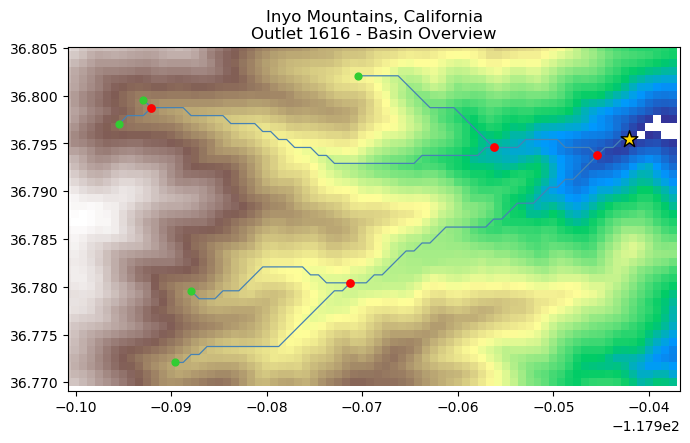


Humboldt Range, Nevada - Outlet 2889


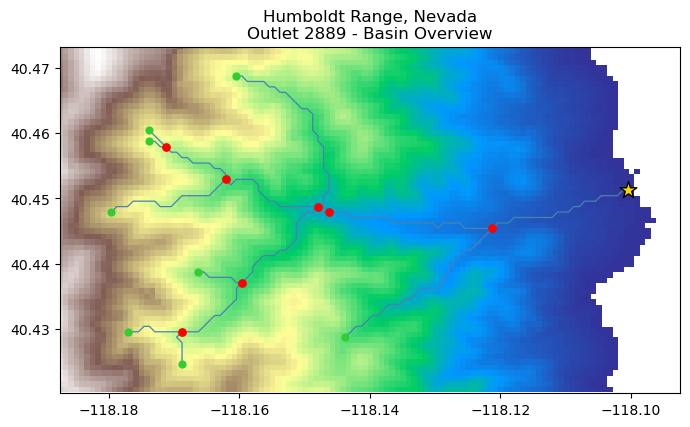


Clan Alpine Mountains, Nevada - Outlet 959


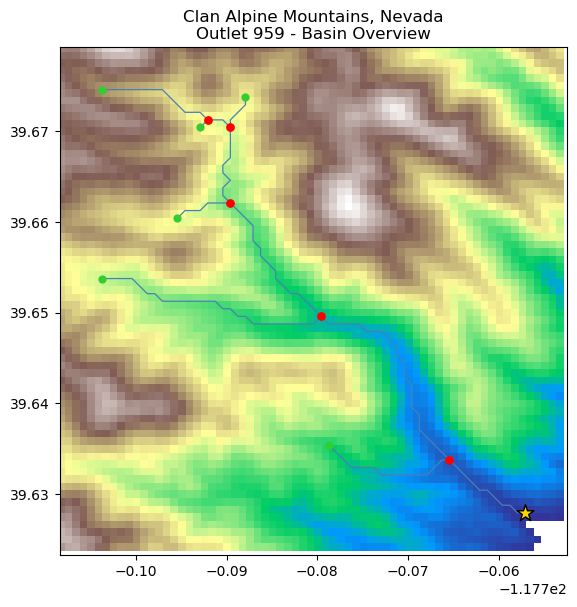


Daquing Shan, China - Outlet 50


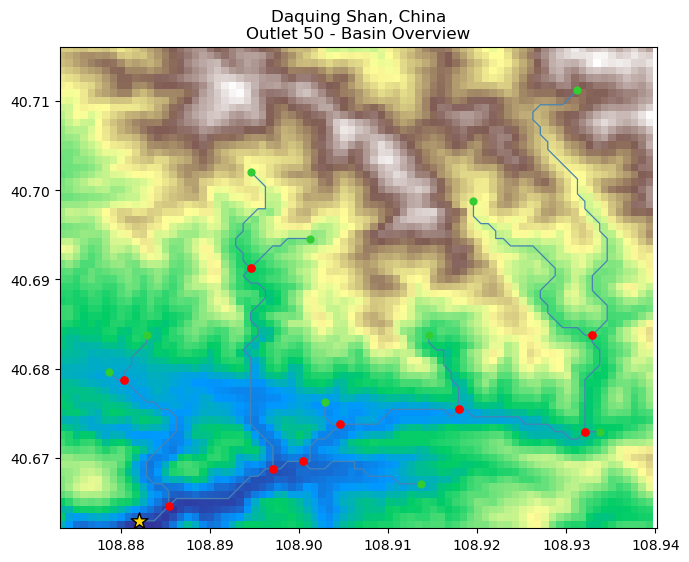


Kammanassie Mountains, South Africa - Outlet 145


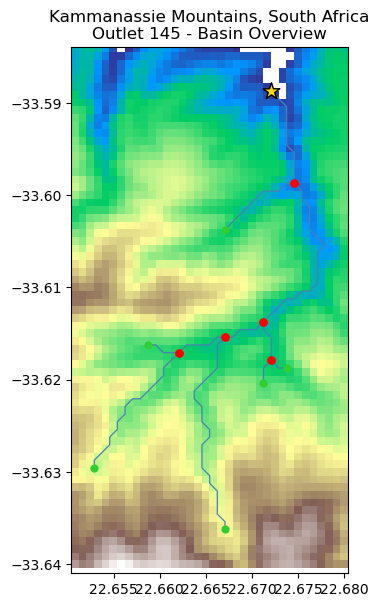


Lüliang Mountains, China - Outlet 880


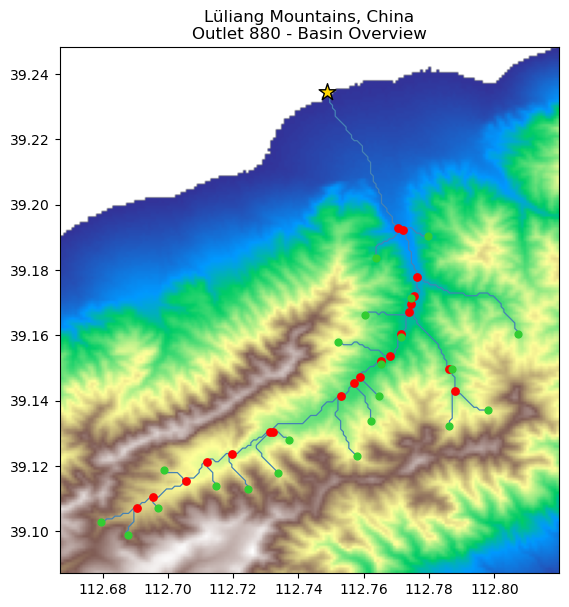

In [7]:
# Plot basin overview for each basin
for basin_name in basin_data.keys():
    data = basin_data[basin_name]
    df = basin_results[basin_name]
    
    if df.empty:
        print(f"No results for {basin_name}")
        continue
    
    # Get the outlet with most touching pairs
    touching_counts = df[df['touching']].groupby('outlet').size()
    if touching_counts.empty:
        # Fall back to outlet with most pairs
        pair_counts = df.groupby('outlet').size()
        best_outlet = pair_counts.idxmax()
    else:
        best_outlet = touching_counts.idxmax()
    
    config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    
    print(f"\n{'='*60}")
    print(f"{config['full_name']} - Outlet {best_outlet}")
    print(f"{'='*60}")
    
    # Plot outlet view
    fig, ax = plot_outlet_view(
        s=data["s"],
        outlet_id=best_outlet,
        dem=data["dem"],
        view_mode="crop",
        pad_frac=0.1,
    )
    ax.set_title(f"{config['full_name']}\nOutlet {best_outlet} - Basin Overview")
    plt.show()

## 7. Visualization: Coupled Channel Head Pairs


Inyo Mountains, California - Coupled Pairs
Total touching pairs: 28

Pair 1: heads (508, 687) at confluence 498
  L_1=117.1m, L_2=1943.8m, ΔL=1.773
  Overlap: 0px, Contact: 53px


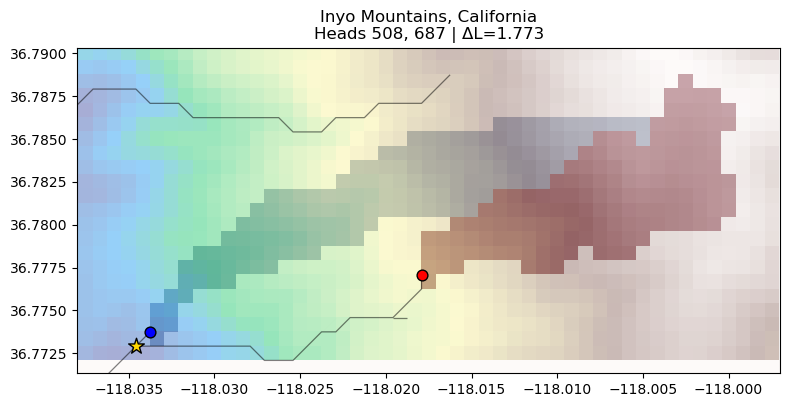


Pair 2: heads (1581, 1651) at confluence 1661
  L_1=930.5m, L_2=82.8m, ΔL=1.673
  Overlap: 0px, Contact: 40px


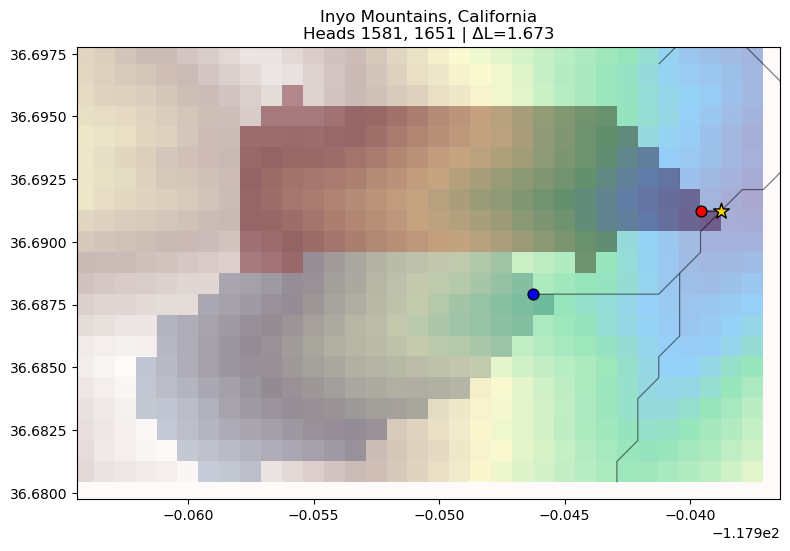


Pair 3: heads (1912, 1975) at confluence 2006
  L_1=2577.6m, L_2=282.6m, ΔL=1.605
  Overlap: 0px, Contact: 13px


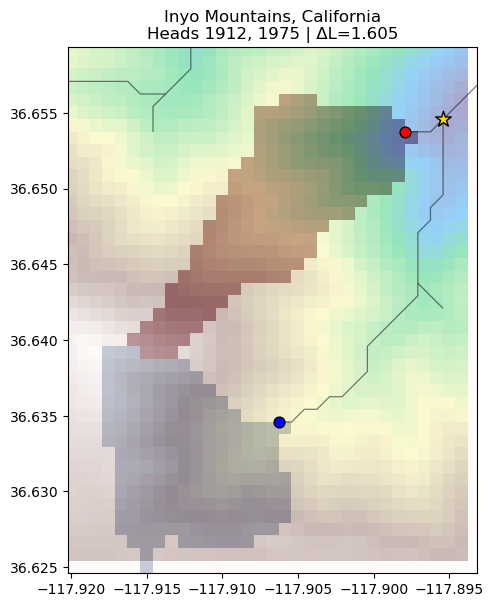


Humboldt Range, Nevada - Coupled Pairs
Total touching pairs: 34

Pair 1: heads (2267, 2778) at confluence 2824
  L_1=2356.9m, L_2=194.6m, ΔL=1.695
  Overlap: 0px, Contact: 6px


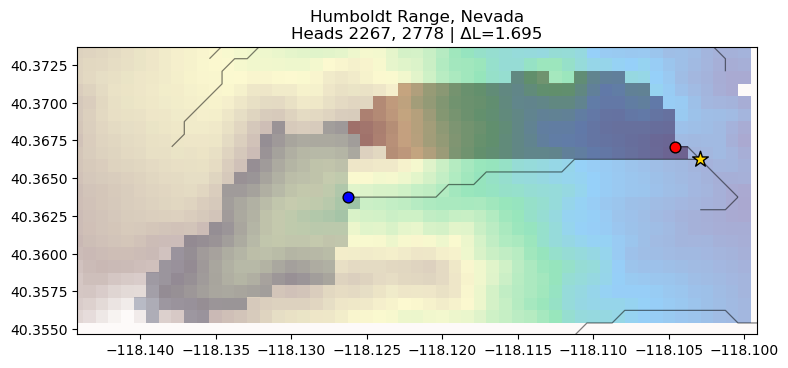


Pair 2: heads (1293, 1370) at confluence 1268
  L_1=194.6m, L_2=1086.9m, ΔL=1.393
  Overlap: 0px, Contact: 48px


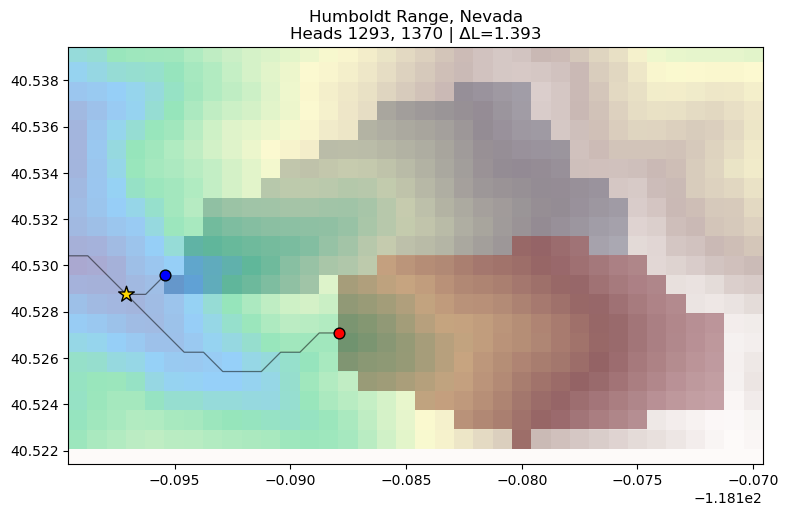


Pair 3: heads (1284, 1341) at confluence 1271
  L_1=114.0m, L_2=564.2m, ΔL=1.328
  Overlap: 0px, Contact: 35px


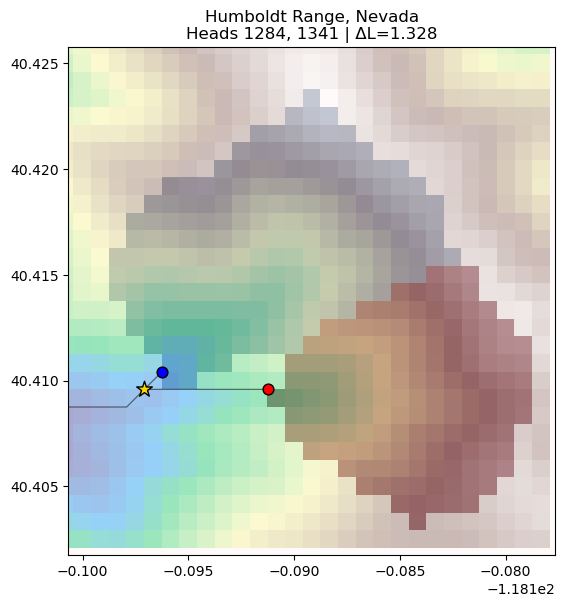


Clan Alpine Mountains, Nevada - Coupled Pairs
Total touching pairs: 24

Pair 1: heads (552, 640) at confluence 646
  L_1=1269.6m, L_2=114.7m, ΔL=1.669
  Overlap: 0px, Contact: 27px


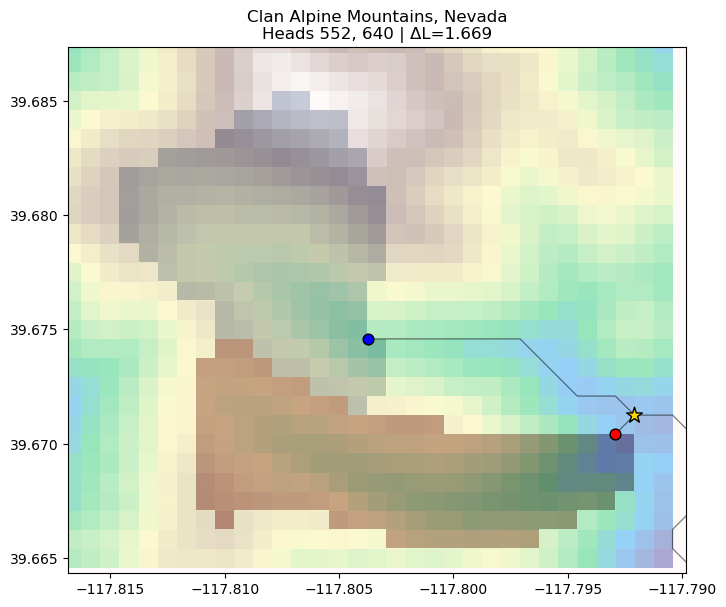


Pair 2: heads (1194, 1282) at confluence 1300
  L_1=1532.6m, L_2=162.2m, ΔL=1.617
  Overlap: 0px, Contact: 33px


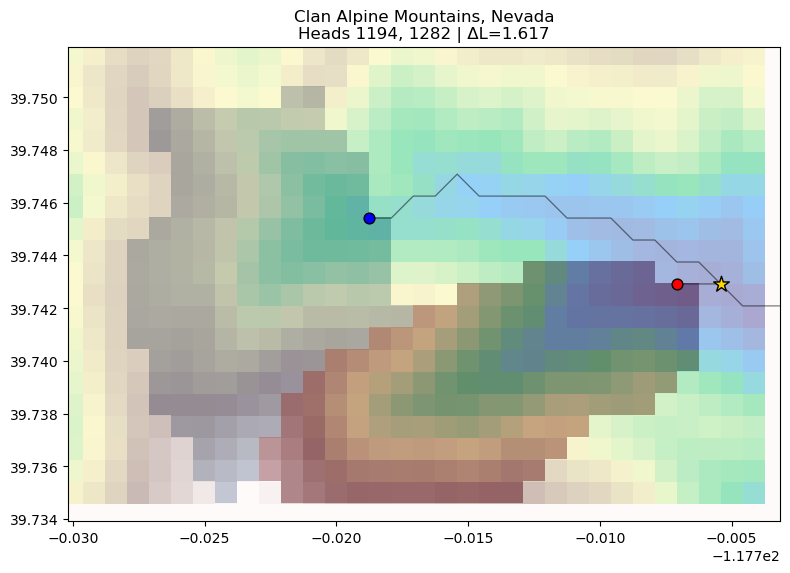


Pair 3: heads (31, 54) at confluence 52
  L_1=945.3m, L_2=162.2m, ΔL=1.414
  Overlap: 0px, Contact: 33px


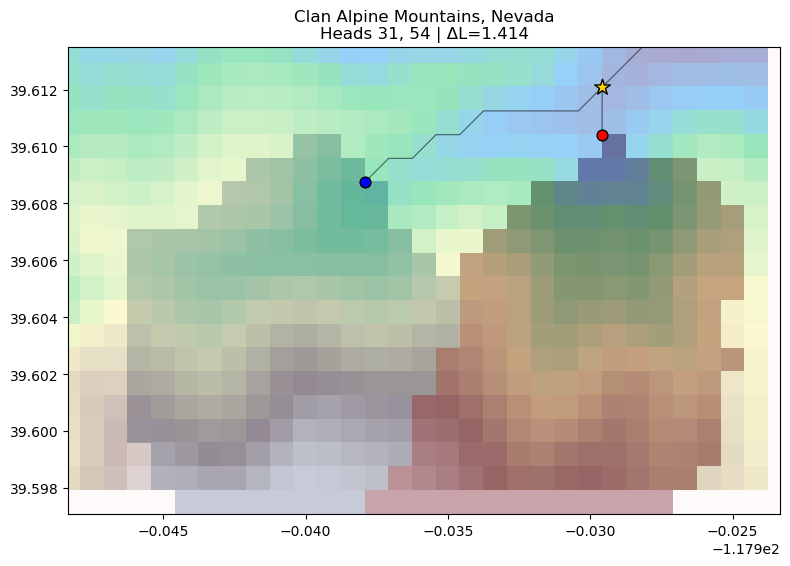


Daquing Shan, China - Coupled Pairs
Total touching pairs: 23

Pair 1: heads (1759, 1870) at confluence 1754
  L_1=194.3m, L_2=1629.2m, ΔL=1.574
  Overlap: 0px, Contact: 8px


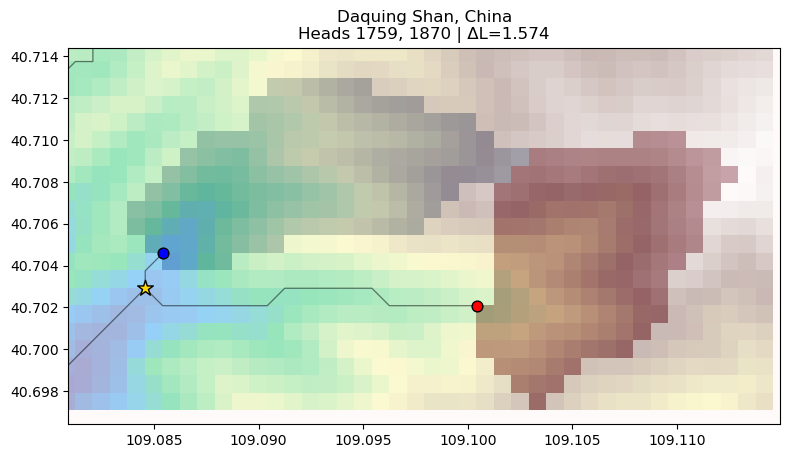


Pair 2: heads (231, 309) at confluence 259
  L_1=355.3m, L_2=2406.4m, ΔL=1.485
  Overlap: 0px, Contact: 24px


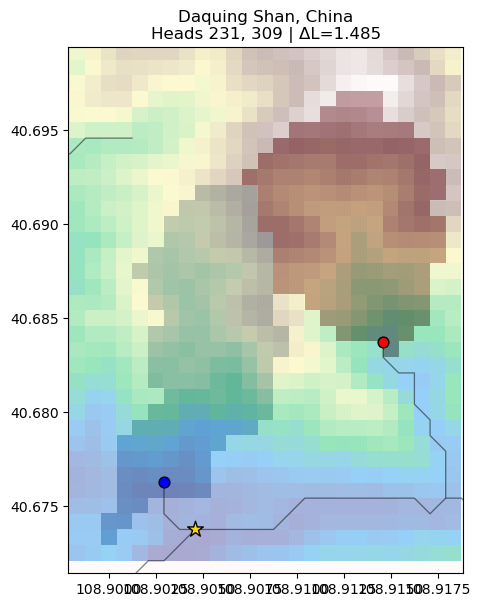


Pair 3: heads (309, 362) at confluence 342
  L_1=985.3m, L_2=5173.8m, ΔL=1.360
  Overlap: 0px, Contact: 6px


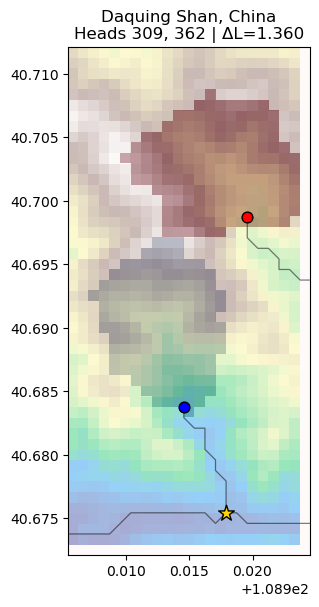


Kammanassie Mountains, South Africa - Coupled Pairs
Total touching pairs: 49

Pair 1: heads (2511, 2548) at confluence 2571
  L_1=2001.6m, L_2=203.7m, ΔL=1.631
  Overlap: 0px, Contact: 24px


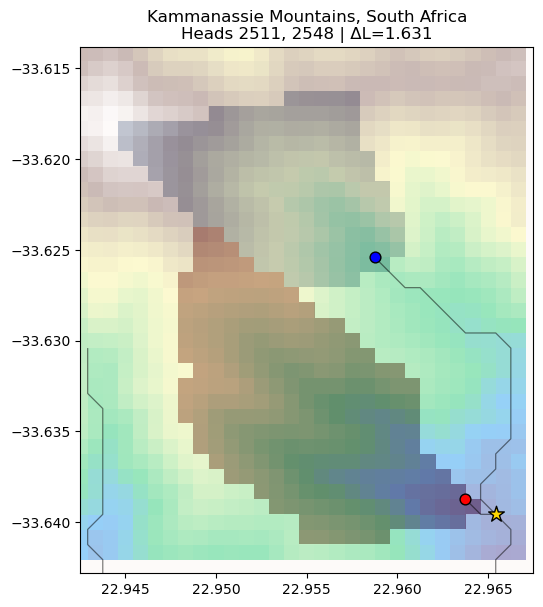


Pair 2: heads (2777, 2814) at confluence 2817
  L_1=2423.4m, L_2=253.1m, ΔL=1.622
  Overlap: 0px, Contact: 28px


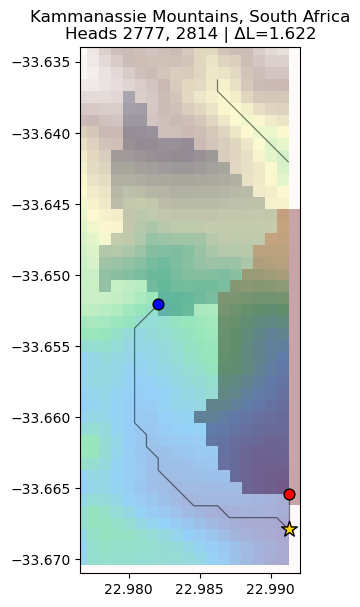


Pair 3: heads (1231, 1267) at confluence 1190
  L_1=238.6m, L_2=2269.1m, ΔL=1.619
  Overlap: 0px, Contact: 25px


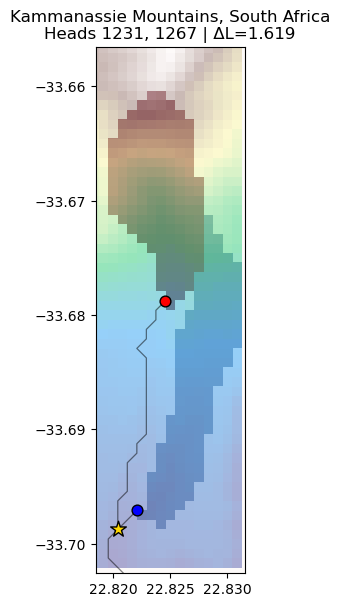


Lüliang Mountains, China - Coupled Pairs
Total touching pairs: 120

Pair 1: heads (1346, 1467) at confluence 1336
  L_1=81.3m, L_2=1929.9m, ΔL=1.838
  Overlap: 0px, Contact: 15px


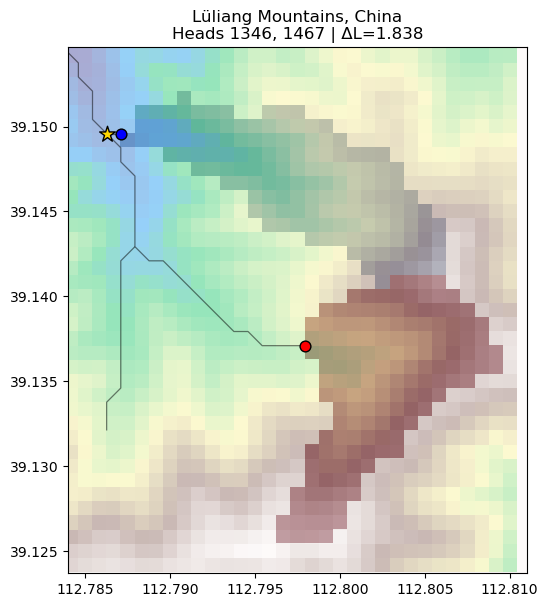


Pair 2: heads (1078, 1090) at confluence 1089
  L_1=1705.7m, L_2=81.3m, ΔL=1.818
  Overlap: 0px, Contact: 52px


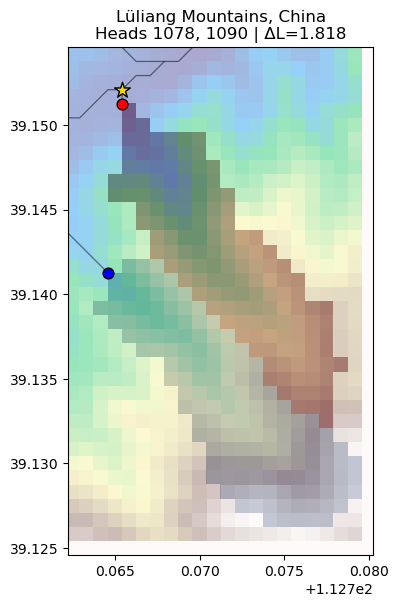


Pair 3: heads (4880, 4897) at confluence 4890
  L_1=196.4m, L_2=3764.6m, ΔL=1.802
  Overlap: 0px, Contact: 16px


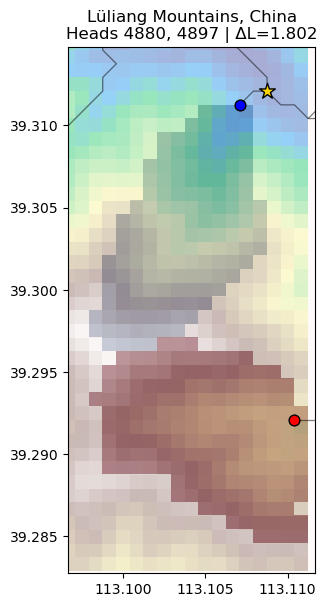

In [8]:
# Plot coupled pairs for each basin
for basin_name in basin_data.keys():
    data = basin_data[basin_name]
    df = basin_results[basin_name]
    
    if df.empty:
        continue
    
    config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    
    # Get touching pairs sorted by delta_L (highest asymmetry first)
    df_touching = df[df['touching'] == True].sort_values('delta_L', ascending=False)
    
    if df_touching.empty:
        print(f"\nNo touching pairs for {basin_name}")
        continue
    
    print(f"\n{'='*60}")
    print(f"{config['full_name']} - Coupled Pairs")
    print(f"Total touching pairs: {len(df_touching)}")
    print(f"{'='*60}")
    
    # Plot top 3 pairs with highest asymmetry
    for i, row in enumerate(df_touching.head(3).itertuples()):
        print(f"\nPair {i+1}: heads ({row.head_1}, {row.head_2}) at confluence {row.confluence}")
        print(f"  L_1={row.L_1:.1f}m, L_2={row.L_2:.1f}m, ΔL={row.delta_L:.3f}")
        print(f"  Overlap: {row.overlap_px}px, Contact: {row.contact_px}px")
        
        try:
            fig, ax = plot_coupled_pair(
                fd=data["fd"],
                s=data["s"],
                dem=data["dem"],
                confluence_id=int(row.confluence),
                head_i=int(row.head_1),
                head_j=int(row.head_2),
                view_mode="crop",
                pad_frac=0.1,
                focus="masks",
            )
            ax.set_title(f"{config['full_name']}\nHeads {row.head_1}, {row.head_2} | ΔL={row.delta_L:.3f}")
            plt.show()
        except Exception as e:
            print(f"  Error plotting: {e}")

## 8. Visualization: All Coupled Pairs for Selected Outlets


Inyo Mountains, California - All Coupled Pairs
Outlet 1616: 4 touching pairs


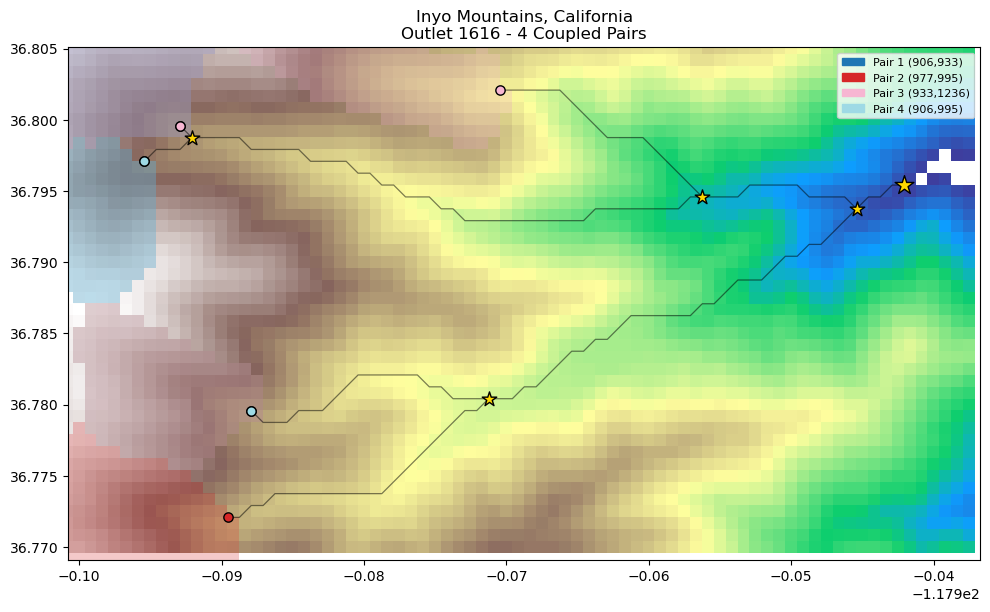


Humboldt Range, Nevada - All Coupled Pairs
Outlet 2889: 5 touching pairs


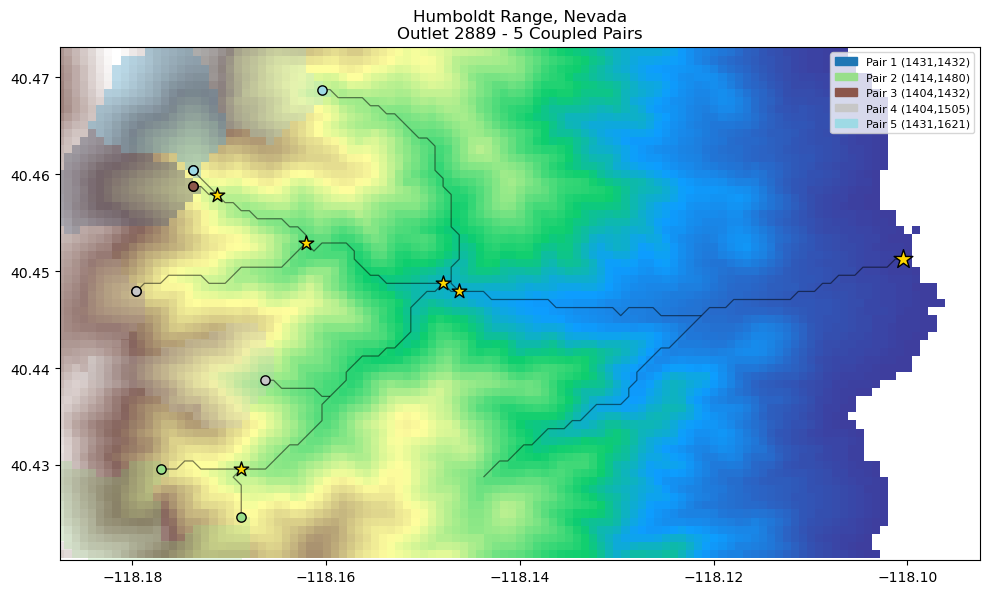


Clan Alpine Mountains, Nevada - All Coupled Pairs
Outlet 959: 4 touching pairs


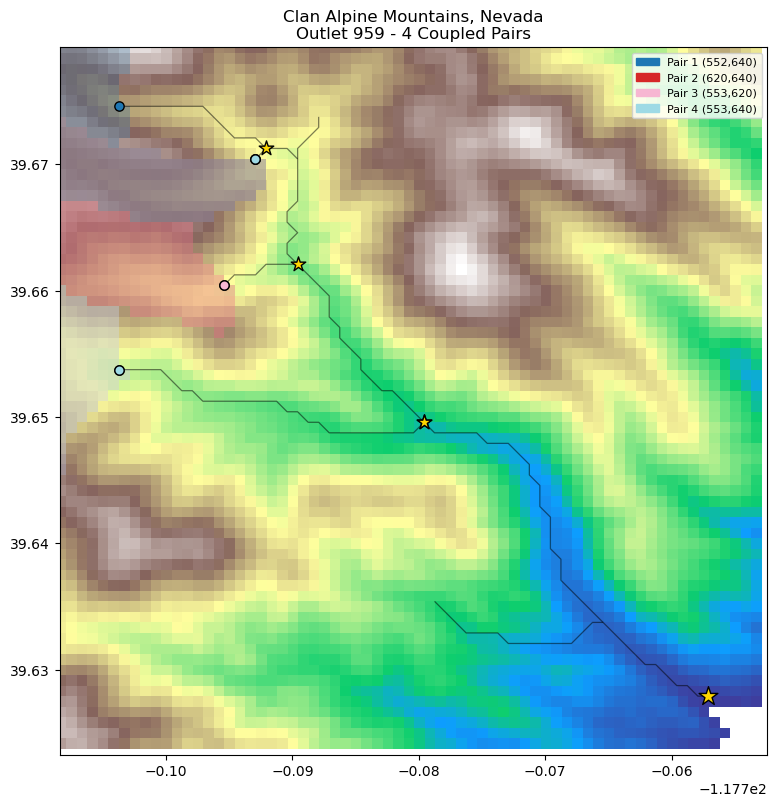


Daquing Shan, China - All Coupled Pairs
Outlet 50: 6 touching pairs


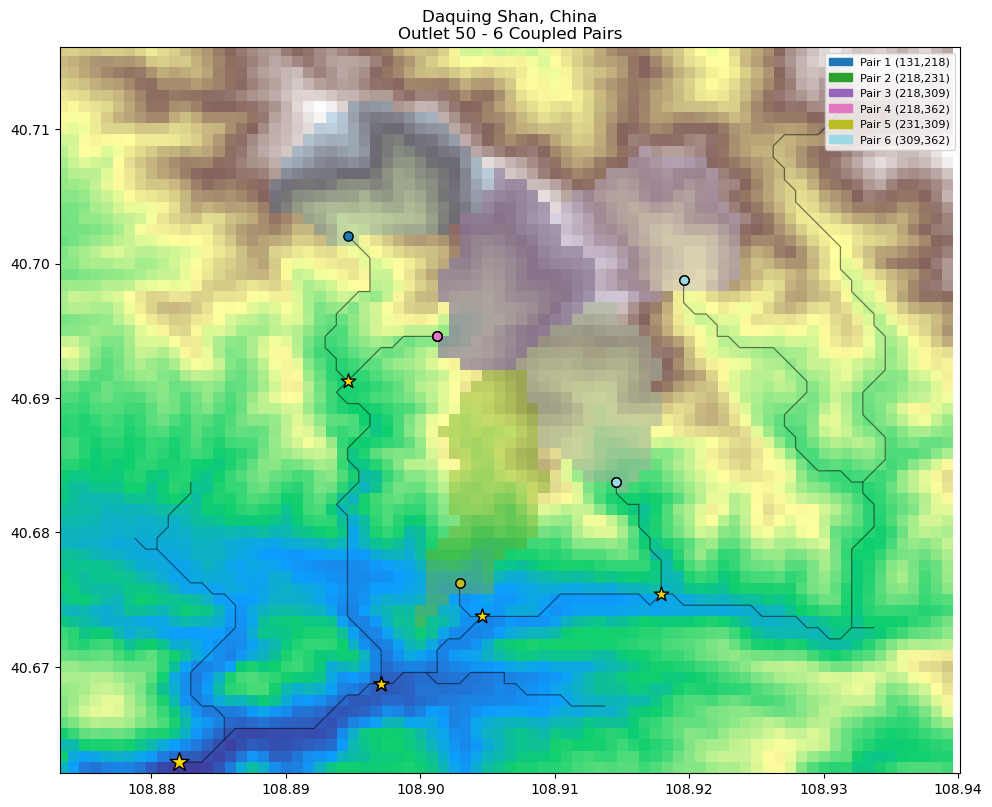


Kammanassie Mountains, South Africa - All Coupled Pairs
Outlet 145: 4 touching pairs


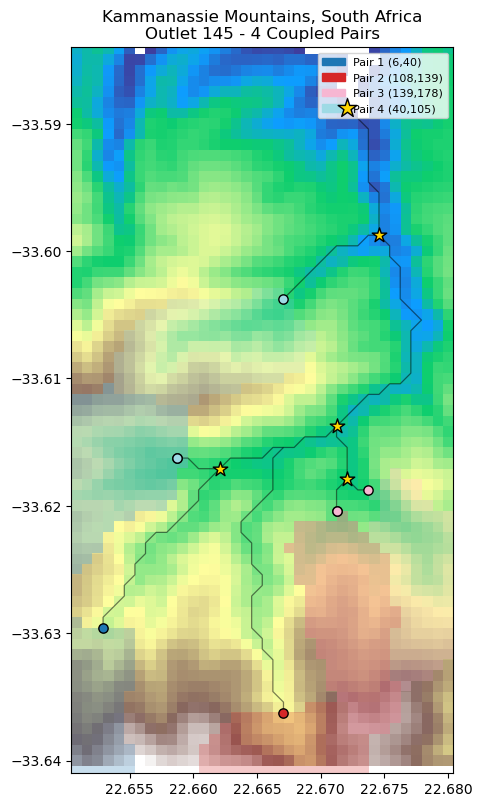


Lüliang Mountains, China - All Coupled Pairs
Outlet 880: 15 touching pairs


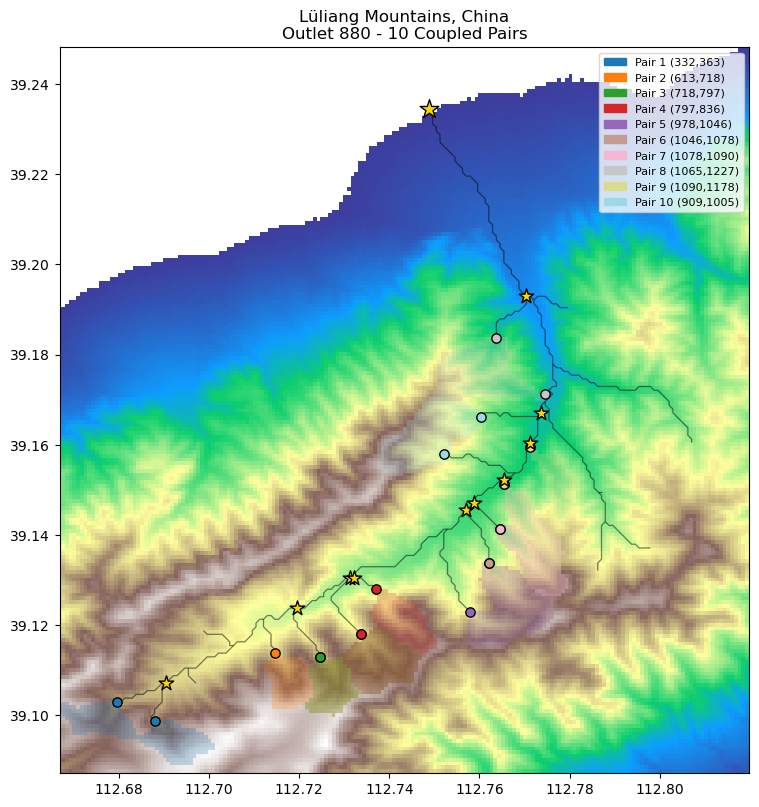

In [9]:
# Plot all coupled pairs for best outlet in each basin
for basin_name in basin_data.keys():
    data = basin_data[basin_name]
    df = basin_results[basin_name]
    
    if df.empty:
        continue
    
    config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    
    # Get the outlet with most touching pairs
    df_touching = df[df['touching'] == True]
    if df_touching.empty:
        continue
    
    touching_counts = df_touching.groupby('outlet').size()
    best_outlet = touching_counts.idxmax()
    n_touching = touching_counts[best_outlet]
    
    print(f"\n{'='*60}")
    print(f"{config['full_name']} - All Coupled Pairs")
    print(f"Outlet {best_outlet}: {n_touching} touching pairs")
    print(f"{'='*60}")
    
    # Create analyzer for plotting
    an = CouplingAnalyzer(data["fd"], data["s"], data["dem"])
    
    try:
        fig, ax = plot_all_coupled_pairs_for_outlet(
            fd=data["fd"],
            s=data["s"],
            dem=data["dem"],
            an=an,
            df_touching=df_touching,
            outlet_id=best_outlet,
            view_mode="crop",
            pad_frac=0.1,
            max_pairs=10,
        )
        if fig:
            ax.set_title(f"{config['full_name']}\nOutlet {best_outlet} - {min(n_touching, 10)} Coupled Pairs")
            plt.show()
    except Exception as e:
        print(f"Error plotting: {e}")

## 9. Lengthwise Asymmetry (ΔL) Distribution

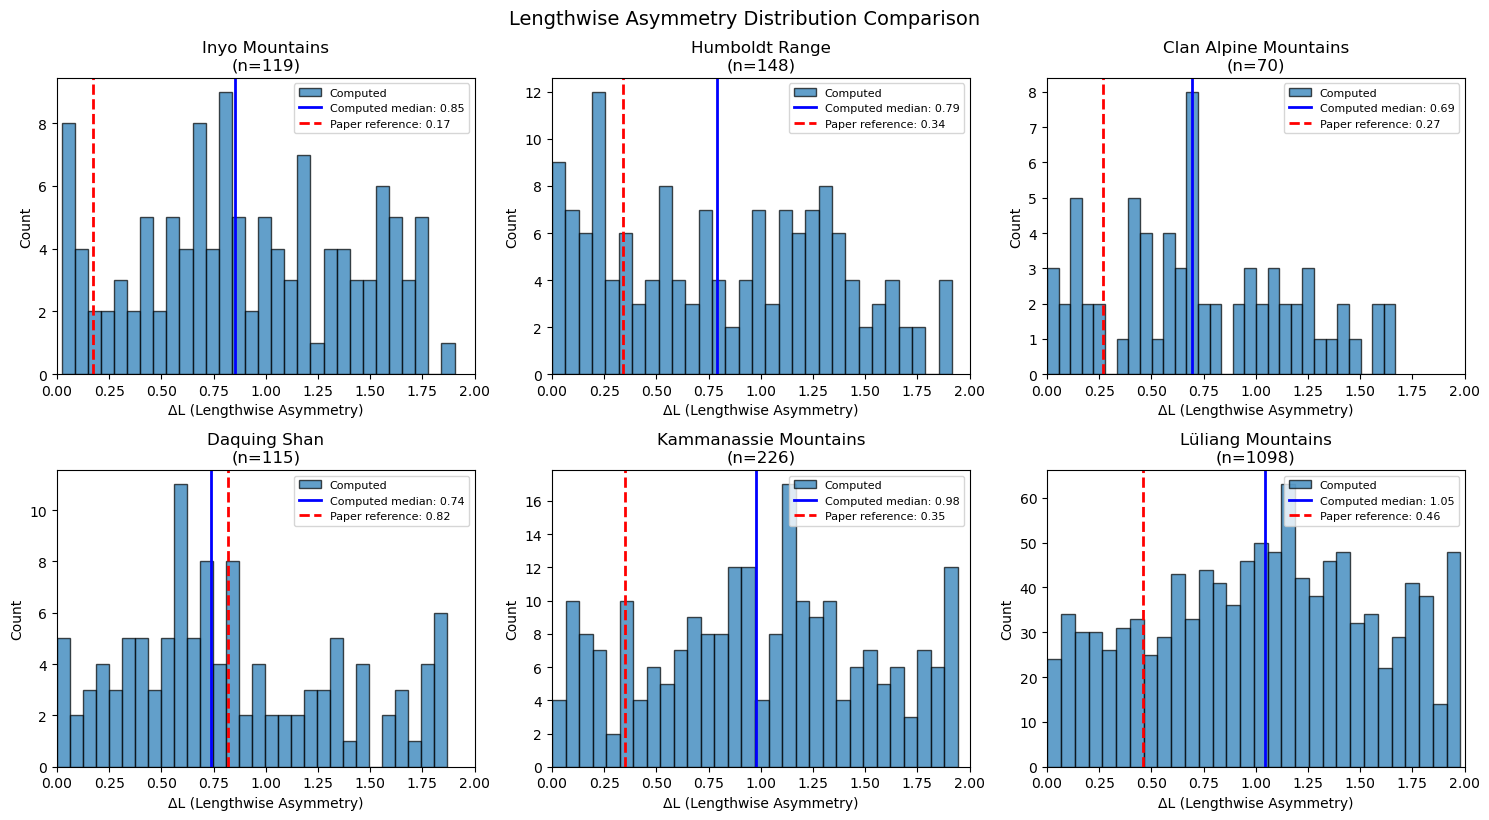

In [10]:
# Plot ΔL distribution for all basins
n_basins = len(basin_results)
n_cols = min(3, n_basins)
n_rows = (n_basins + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = np.atleast_1d(axes).flatten()

for idx, (basin_name, df) in enumerate(basin_results.items()):
    ax = axes[idx]
    
    if df.empty:
        ax.set_title(f"{basin_name}: No data")
        continue
    
    config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    ref = get_reference_delta_L(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    
    # Get ΔL values
    delta_L = df['delta_L'].dropna()
    stats = compute_asymmetry_statistics(delta_L)
    
    # Plot histogram
    ax.hist(delta_L, bins=30, alpha=0.7, edgecolor='black', label='Computed')
    
    # Add reference lines
    ax.axvline(stats['median'], color='blue', linestyle='-', linewidth=2, 
               label=f'Computed median: {stats["median"]:.2f}')
    ax.axvline(ref['median'], color='red', linestyle='--', linewidth=2,
               label=f'Paper reference: {ref["median"]:.2f}')
    
    ax.set_xlabel('ΔL (Lengthwise Asymmetry)')
    ax.set_ylabel('Count')
    ax.set_title(f"{config['full_name'].split(',')[0]}\n(n={len(delta_L)})")
    ax.legend(fontsize=8)
    ax.set_xlim(0, 2)

# Hide unused subplots
for idx in range(len(basin_results), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.suptitle('Lengthwise Asymmetry Distribution Comparison', y=1.02, fontsize=14)
plt.show()

## 10. Comparison with Paper Reference Values

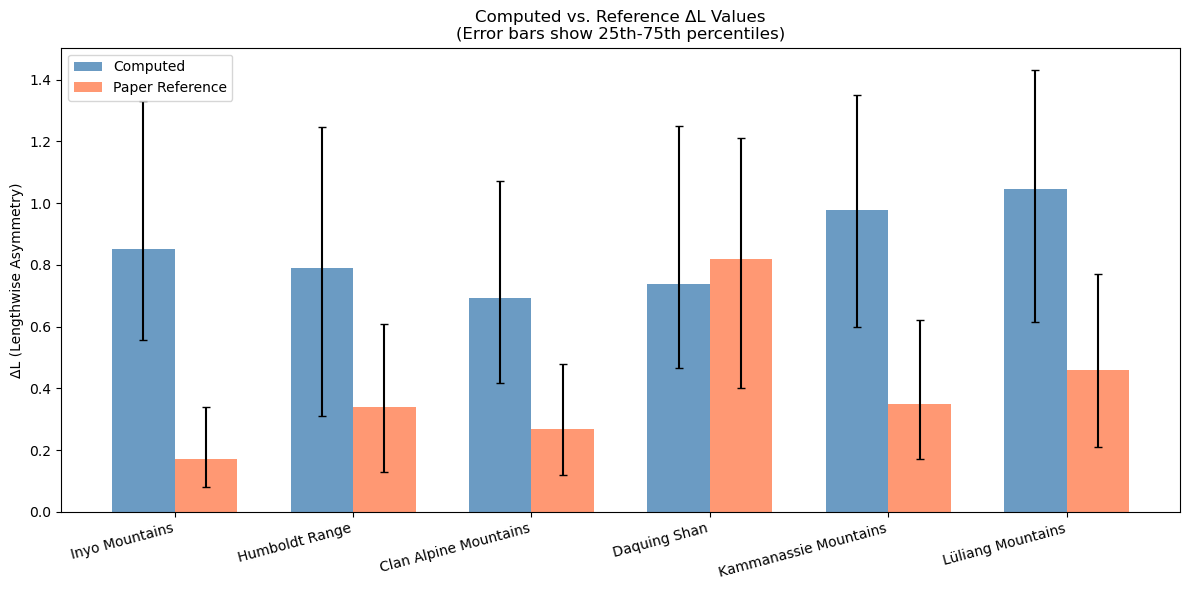


=== Computed vs. Reference ΔL ===
Basin                               Computed                  Reference                
-------------------------------------------------------------------------------------
Inyo Mountains, California          0.85 (0.56-1.33)          0.17 (0.08-0.34)         
Humboldt Range, Nevada              0.79 (0.31-1.25)          0.34 (0.13-0.61)         
Clan Alpine Mountains, Nevada       0.69 (0.42-1.07)          0.27 (0.12-0.48)         
Daquing Shan, China                 0.74 (0.47-1.25)          0.82 (0.40-1.21)         
Kammanassie Mountains, South Africa 0.98 (0.60-1.35)          0.35 (0.17-0.62)         
Lüliang Mountains, China            1.05 (0.61-1.43)          0.46 (0.21-0.77)         


In [11]:
# Create comparison plot
fig, ax = plt.subplots(figsize=(12, 6))

x_positions = []
computed_medians = []
computed_errors = []
reference_medians = []
reference_errors = []
labels = []

for i, basin_name in enumerate(basin_results.keys()):
    df = basin_results[basin_name]
    if df.empty:
        continue
    
    config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    ref = get_reference_delta_L(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    stats = compute_asymmetry_statistics(df['delta_L'].dropna())
    
    x_positions.append(len(x_positions))
    labels.append(config['full_name'].split(',')[0])  # Short name
    
    computed_medians.append(stats['median'])
    computed_errors.append([[stats['median'] - stats['p25']], [stats['p75'] - stats['median']]])
    
    reference_medians.append(ref['median'])
    reference_errors.append([[ref['median'] - ref['p25']], [ref['p75'] - ref['median']]])

# Plot
x = np.array(x_positions)
width = 0.35

# Computed values
ax.bar(x - width/2, computed_medians, width, label='Computed', color='steelblue', alpha=0.8)
for i, (pos, med, err) in enumerate(zip(x - width/2, computed_medians, computed_errors)):
    ax.errorbar(pos, med, yerr=err, fmt='none', color='black', capsize=3)

# Reference values
ax.bar(x + width/2, reference_medians, width, label='Paper Reference', color='coral', alpha=0.8)
for i, (pos, med, err) in enumerate(zip(x + width/2, reference_medians, reference_errors)):
    ax.errorbar(pos, med, yerr=err, fmt='none', color='black', capsize=3)

ax.set_ylabel('ΔL (Lengthwise Asymmetry)')
ax.set_title('Computed vs. Reference ΔL Values\n(Error bars show 25th-75th percentiles)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=15, ha='right')
ax.legend()
ax.set_ylim(0, None)

plt.tight_layout()
plt.show()

# Print comparison table
print("\n=== Computed vs. Reference ΔL ===")
print(f"{'Basin':<35} {'Computed':<25} {'Reference':<25}")
print("-" * 85)
for basin_name, df in basin_results.items():
    if df.empty:
        continue
    config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    ref = get_reference_delta_L(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    stats = compute_asymmetry_statistics(df['delta_L'].dropna())
    
    comp_str = f"{stats['median']:.2f} ({stats['p25']:.2f}-{stats['p75']:.2f})"
    ref_str = f"{ref['median']:.2f} ({ref['p25']:.2f}-{ref['p75']:.2f})"
    print(f"{config['full_name']:<35} {comp_str:<25} {ref_str:<25}")

## 11. Aridity Index vs. Lengthwise Asymmetry

Scatter plot comparing aridity index with lengthwise asymmetry (ΔL) from the paper reference values, with error bars showing the 25th-75th percentile ranges for both variables.

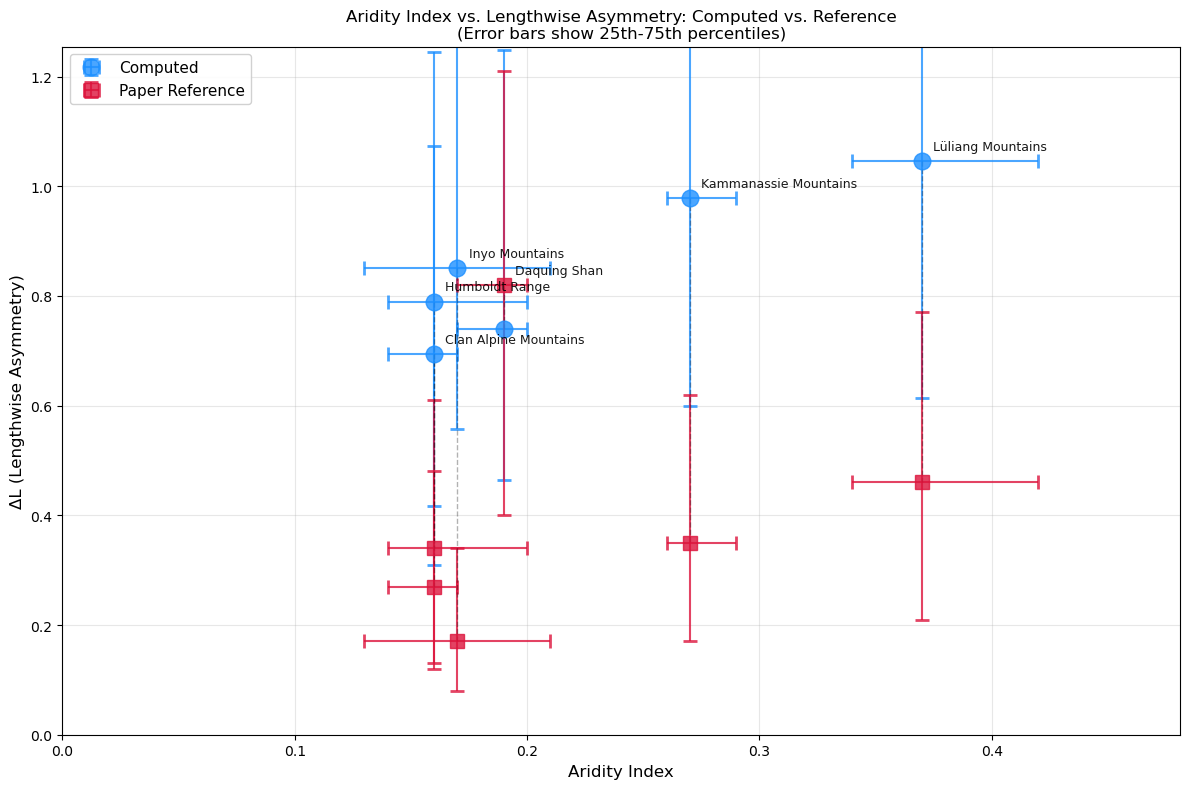


=== Aridity Index vs. ΔL Comparison ===
Basin                          Aridity      Computed ΔL          Reference ΔL        
----------------------------------------------------------------------------------
Inyo Mountains                 0.17         0.85 (0.56-1.33)     0.17 (0.08-0.34)    
Humboldt Range                 0.16         0.79 (0.31-1.25)     0.34 (0.13-0.61)    
Clan Alpine Mountains          0.16         0.69 (0.42-1.07)     0.27 (0.12-0.48)    
Daquing Shan                   0.19         0.74 (0.47-1.25)     0.82 (0.40-1.21)    
Kammanassie Mountains          0.27         0.98 (0.60-1.35)     0.35 (0.17-0.62)    
Lüliang Mountains              0.37         1.05 (0.61-1.43)     0.46 (0.21-0.77)    


In [12]:
# Scatter plot: Aridity Index vs. Lengthwise Asymmetry (ΔL)
# Comparing computed ΔL values with paper reference values

fig, ax = plt.subplots(figsize=(12, 8))

# Collect data for all analyzed basins
basin_names_list = []
aridity_vals = []
aridity_errs_lower = []
aridity_errs_upper = []
computed_delta_L = []
computed_delta_L_errs_lower = []
computed_delta_L_errs_upper = []
reference_delta_L = []
reference_delta_L_errs_lower = []
reference_delta_L_errs_upper = []

for basin_name, df in basin_results.items():
    if df.empty:
        continue
    
    config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    
    # Aridity index from paper
    aridity = config["aridity_index"]
    aridity_25 = config["aridity_index_25"]
    aridity_75 = config["aridity_index_75"]
    
    # Computed Delta L from our analysis
    stats = compute_asymmetry_statistics(df['delta_L'].dropna())
    
    # Reference Delta L from paper
    ref = get_reference_delta_L(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    
    basin_names_list.append(config['full_name'].split(',')[0])
    
    aridity_vals.append(aridity)
    aridity_errs_lower.append(aridity - aridity_25)
    aridity_errs_upper.append(aridity_75 - aridity)
    
    computed_delta_L.append(stats['median'])
    computed_delta_L_errs_lower.append(stats['median'] - stats['p25'])
    computed_delta_L_errs_upper.append(stats['p75'] - stats['median'])
    
    reference_delta_L.append(ref['median'])
    reference_delta_L_errs_lower.append(ref['median'] - ref['p25'])
    reference_delta_L_errs_upper.append(ref['p75'] - ref['median'])

# Plot computed values (blue circles)
for i in range(len(aridity_vals)):
    ax.errorbar(
        aridity_vals[i], computed_delta_L[i],
        xerr=[[aridity_errs_lower[i]], [aridity_errs_upper[i]]],
        yerr=[[computed_delta_L_errs_lower[i]], [computed_delta_L_errs_upper[i]]],
        fmt='o', markersize=12, capsize=5, capthick=2,
        color='dodgerblue', ecolor='dodgerblue', alpha=0.8,
        label='Computed' if i == 0 else None
    )

# Plot reference values (red squares)
for i in range(len(aridity_vals)):
    ax.errorbar(
        aridity_vals[i], reference_delta_L[i],
        xerr=[[aridity_errs_lower[i]], [aridity_errs_upper[i]]],
        yerr=[[reference_delta_L_errs_lower[i]], [reference_delta_L_errs_upper[i]]],
        fmt='s', markersize=10, capsize=5, capthick=2,
        color='crimson', ecolor='crimson', alpha=0.8,
        label='Paper Reference' if i == 0 else None
    )

# Draw lines connecting computed and reference for each basin
for i in range(len(aridity_vals)):
    ax.plot([aridity_vals[i], aridity_vals[i]], 
            [computed_delta_L[i], reference_delta_L[i]], 
            'k--', alpha=0.3, linewidth=1)

# Add labels to computed points
for i, label in enumerate(basin_names_list):
    # Position label above or below based on which point is higher
    if computed_delta_L[i] >= reference_delta_L[i]:
        y_pos = computed_delta_L[i]
        xytext = (8, 8)
    else:
        y_pos = reference_delta_L[i]
        xytext = (8, 8)
    
    ax.annotate(
        label, 
        (aridity_vals[i], y_pos),
        textcoords="offset points",
        xytext=xytext,
        fontsize=9,
        alpha=0.9
    )

ax.set_xlabel('Aridity Index', fontsize=12)
ax.set_ylabel('ΔL (Lengthwise Asymmetry)', fontsize=12)
ax.set_title('Aridity Index vs. Lengthwise Asymmetry: Computed vs. Reference\n(Error bars show 25th-75th percentiles)', fontsize=12)
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)

# Set axis limits with some padding
all_delta_L = computed_delta_L + reference_delta_L
ax.set_xlim(0, max(aridity_vals) * 1.3)
ax.set_ylim(0, max(all_delta_L) * 1.2)

plt.tight_layout()
plt.show()

# Print comparison table
print("\n=== Aridity Index vs. ΔL Comparison ===")
print(f"{'Basin':<30} {'Aridity':<12} {'Computed ΔL':<20} {'Reference ΔL':<20}")
print("-" * 82)
for i, basin_name in enumerate(basin_results.keys()):
    if basin_results[basin_name].empty:
        continue
    config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    stats = compute_asymmetry_statistics(basin_results[basin_name]['delta_L'].dropna())
    ref = get_reference_delta_L(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    
    name = config['full_name'].split(',')[0]
    aridity_str = f"{config['aridity_index']:.2f}"
    computed_str = f"{stats['median']:.2f} ({stats['p25']:.2f}-{stats['p75']:.2f})"
    ref_str = f"{ref['median']:.2f} ({ref['p25']:.2f}-{ref['p75']:.2f})"
    print(f"{name:<30} {aridity_str:<12} {computed_str:<20} {ref_str:<20}")

## Summary

This notebook analyzed **all available basins** for coupled channel heads and lengthwise asymmetry:

1. **Coupling Analysis**: Identified channel head pairs whose drainage basins touch or overlap
2. **Lengthwise Asymmetry (ΔL)**: Computed using flow path lengths from Goren & Shelef (2024)
3. **Comparison**: Results compared with reference values from the paper
4. **Climate Relationship**: Explored the relationship between aridity index and lengthwise asymmetry

Key findings:
- The `z_th` elevation thresholds from the paper were applied to mask each DEM
- Stream networks were extracted with a configurable threshold (default: 145 contributing pixels)
- ΔL values measure the normalized difference in flow path lengths between paired channel heads
- The aridity index vs. ΔL scatter plot shows how climate may influence drainage network asymmetry